In [13]:
#Predecir o valor de crédito aprovado utilizando os valores de crédito dos 7 dias anteriores
# Ele prediz os próximos dois dias
#
#
#


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back:i + look_back+1, 0])
    return np.array(dataX), np.array(dataY)

np.random.seed(7)



In [14]:
#Carrega Dados
df=arquivo = pd.read_csv('https://raw.githubusercontent.com/jblancoperez/fiap-desafio/main/solicitacoescredito.csv')

#Somente linhas com Valor Aprovado
df=df.loc[df['valorAprovado']>0]

#Conslolida os valores aprovados em uma coluna
df['dataAprovado'] = np.where(df['status'] == 'AprovadoAnalista', df['dataAprovadoNivelAnalista'], df['dataAprovadoEmComite'])

#Somente precisamos de data e valor
df=df[['dataAprovado','valorAprovado']]

#Coloca a Data como uma tipo data
df['dataAprovado']=pd.to_datetime(pd.to_datetime(df['dataAprovado'],errors='coerce').dt.date)
#Consolida os valores aprovados por data
df=df.groupby('dataAprovado',as_index = False)['valorAprovado'].sum()

#Ordena crescente pela data
df=df.sort_values('dataAprovado')



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:


#Somente temos uma feature, precisamos de uma array na entrada

X = df.valorAprovado.values.reshape(-1, 1)
X = X.astype('float32')

#Normaliza o dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#scaler = StandardScaler()
X = scaler.fit_transform(X)

# split into train and test sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:train_size,:]
test =  X[train_size:len(X),:]

# quantidade de atrasos
look_back = 7
n_steps_out=2

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train,(y_train.shape[0],y_train.shape[1],1))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)






model = Sequential()
model.add(LSTM(400, activation='relu', input_shape=(look_back, 1)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(400, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))




model.compile(loss='mean_squared_error', optimizer='adam')


history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1,callbacks=[callback])



Epoch 1/100
175/175 [==============================] - 8s 32ms/step - loss: 0.0111
Epoch 2/100
175/175 [==============================] - 6s 33ms/step - loss: 0.0116: 0s - 
Epoch 3/100
175/175 [==============================] - 6s 33ms/step - loss: 0.0105
Epoch 4/100
175/175 [==============================] - 6s 33ms/step - loss: 0.0108
Epoch 5/100
175/175 [==============================] - 6s 33ms/step - loss: 0.0085
Epoch 6/100
175/175 [==============================] - 6s 33ms/step - loss: 0.0101
Epoch 7/100
175/175 [==============================] - 6s 32ms/step - loss: 0.0086
Epoch 8/100
175/175 [==============================] - 6s 34ms/step - loss: 0.0109
Epoch 9/100
175/175 [==============================] - 6s 33ms/step - loss: 0.0092
Epoch 10/100
175/175 [==============================] - 6s 34ms/step - loss: 0.0110
Epoch 11/100
175/175 [==============================] - 6s 31ms/step - loss: 0.0126
Epoch 12/100
175/175 [==============================] - 5s 30ms/step - loss: 0

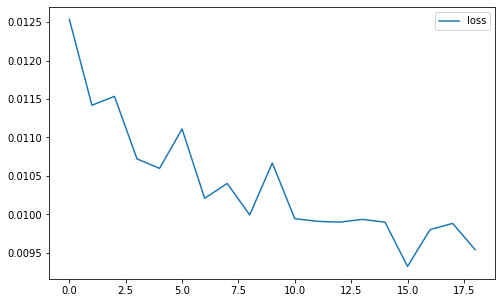

In [16]:
#Plotamos a visão de treinamento do modelo

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Train Score: 1430.01 MAE
Test Score: 6174581.00 MAE


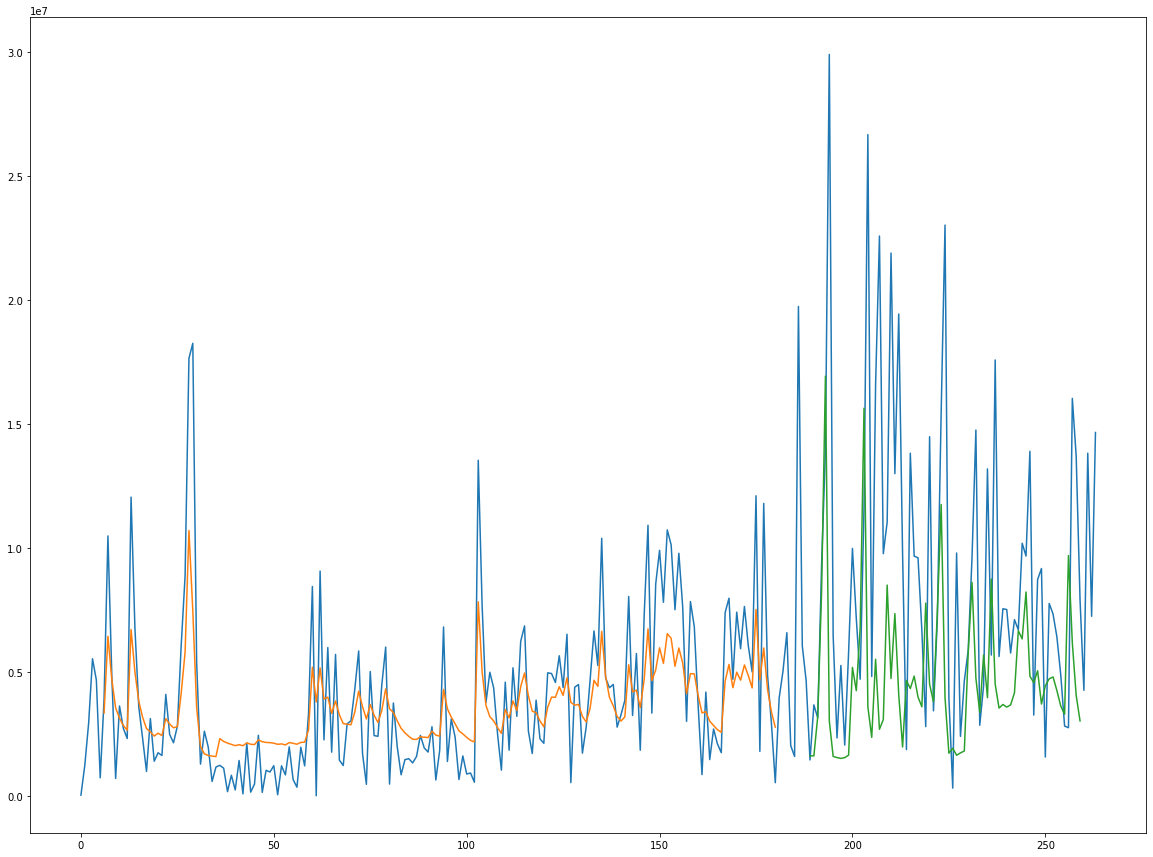

In [17]:
def shift_array(array, place):
    new_arr = np.roll(array, place, axis=0)
    new_arr[:place] = np.zeros((new_arr[:place].shape))
    return new_arr

# PrediÃ§Ãµes
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)


# Faz a transformaÃ§Ã£o inversa das prediÃ§Ãµes
trainPredict = scaler.inverse_transform(trainPredict[:,0])
y_train = scaler.inverse_transform(y_train[:,0].reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict[:,0])
y_test = scaler.inverse_transform(y_test[:,0].reshape(-1, 1))


trainScore = math.sqrt(mean_absolute_error(y_train[:,0], trainPredict[:,0]))
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(y_test[:,0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))



#trainScore2 = math.sqrt(mean_squared_error(shift_array(y_train[:,0],1), shift_array(trainPredict[:,0],1)))
#print('Train Score: %.2f RMSE' % (trainScore2))
#testScore2 = mean_absolute_error(shift_array(y_test[:,0],1), shift_array(testPredict[:,0],1))
#print('Test Score: %.2f RMSE' % (testScore2))






# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

# # Prepara o vetor para plotagem do conjunto das prediÃ§Ãµes
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-4, :] = testPredict

# Plota o dataset, as prediÃ§Ãµes sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,15))
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()




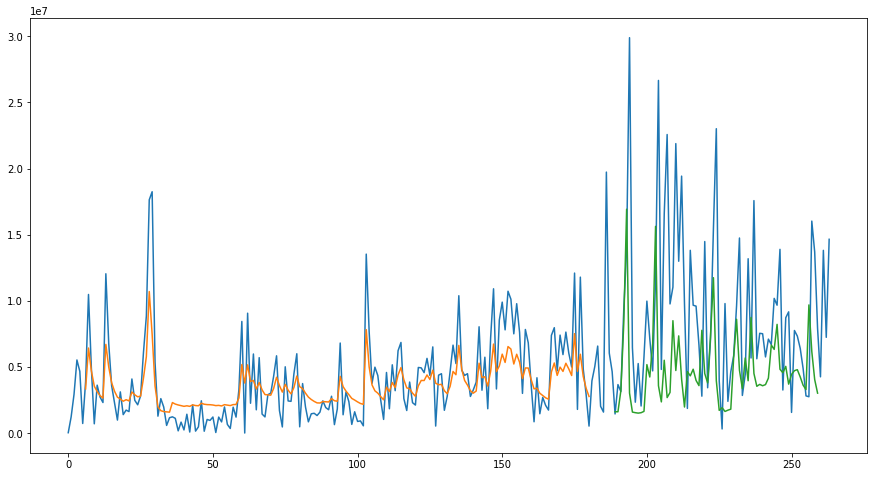

In [18]:
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()